# Import Libraries

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)

# from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
import xgboost as xgb
from xgboost import XGBClassifier

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# import shap

pd.set_option('display.max_rows', 250)

# Importing Data

In [11]:
raw_data = pd.read_csv("../input/patient/dataset.csv")
raw_data

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,Unnamed: 83,hospital_death
0,66154,25312,118,68.0,22.730000,0,Caucasian,M,180.3,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
1,114252,59342,81,77.0,27.420000,0,Caucasian,F,160.0,Floor,...,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0
2,119783,50777,118,25.0,31.950000,0,Caucasian,F,172.7,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
3,79267,46918,118,81.0,22.640000,1,Caucasian,F,165.1,Operating Room / Recovery,...,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,NaN,0
4,92056,34377,33,19.0,NaN,0,Caucasian,M,188.0,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,91592,78108,30,75.0,23.060250,0,Caucasian,M,177.8,Floor,...,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,NaN,0
91709,66119,13486,121,56.0,47.179671,0,Caucasian,F,183.0,Floor,...,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,NaN,0
91710,8981,58179,195,48.0,27.236914,0,Caucasian,M,170.2,Accident & Emergency,...,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,NaN,0
91711,33776,120598,66,NaN,23.297481,0,Caucasian,F,154.9,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,NaN,0


# EDA

In [12]:
raw_data.shape

(91713, 85)

In [13]:
raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

In [14]:
raw_data.describe()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,Unnamed: 83,hospital_death
count,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90379.000000,91713.000000,91713.000000,88993.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,0.0,91713.000000
mean,65606.079280,65537.131464,105.669262,62.309516,29.185818,0.183736,169.641588,508.357692,0.835766,84.028340,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,0.086302
std,37795.088538,37811.252183,62.854406,16.775119,8.275142,0.387271,10.795378,228.989661,2.487756,25.011497,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,0.280811
min,1.000000,1.000000,2.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,38.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,32852.000000,32830.000000,47.000000,52.000000,23.641975,0.000000,162.500000,369.000000,0.035417,66.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
50%,65665.000000,65413.000000,109.000000,65.000000,27.654655,0.000000,170.100000,504.000000,0.138889,80.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
75%,98342.000000,98298.000000,161.000000,75.000000,32.930206,0.000000,177.800000,679.000000,0.409028,97.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
max,131051.000000,131051.000000,204.000000,89.000000,67.814990,1.000000,195.590000,927.000000,159.090972,186.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000


In [15]:
raw_data.isnull().sum(axis=0).sort_values(ascending=False)

Unnamed: 83                      91713
d1_potassium_max                  9585
d1_potassium_min                  9585
h1_mbp_noninvasive_min            9084
h1_mbp_noninvasive_max            9084
apache_4a_hospital_death_prob     7947
apache_4a_icu_death_prob          7947
h1_diasbp_noninvasive_min         7350
h1_diasbp_noninvasive_max         7350
h1_sysbp_noninvasive_min          7341
h1_sysbp_noninvasive_max          7341
d1_glucose_min                    5807
d1_glucose_max                    5807
h1_mbp_max                        4639
h1_mbp_min                        4639
h1_resprate_min                   4357
h1_resprate_max                   4357
age                               4228
h1_spo2_min                       4185
h1_spo2_max                       4185
temp_apache                       4108
h1_diasbp_min                     3619
h1_diasbp_max                     3619
h1_sysbp_min                      3611
h1_sysbp_max                      3611
bmi                      

columns that can be dropped: **'encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'**


Notice the amount of missing values in each row  
We decide a threshold value to delete some of the attributes from the dataset (25k in this approach)  
**74** columns will get deleted in this turn.

In [16]:
print("Number of rows with missing values:", raw_data.isnull().any(axis=1).sum())

Number of rows with missing values: 91713


In [17]:
large_missing = raw_data.isnull().sum(axis=0).sort_values(ascending=False)[raw_data.isnull().sum(axis=0).sort_values(ascending=False) > 25000]

print("\nTotal features with more than", 25000, "missing values:", len(large_missing))

raw_data.drop(large_missing.index.tolist() + ['encounter_id', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id'], 
              axis=1,
             inplace = True)
raw_data


Total features with more than 25000 missing values: 1


,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,108.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,203.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
4,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,0
91709,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
91710,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,123.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
91711,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0


In [18]:
raw_data.nunique()

age                                 74
bmi                              34888
elective_surgery                     2
ethnicity                            6
gender                               2
height                             401
icu_type                             8
pre_icu_los_days                  9757
weight                            3409
apache_2_diagnosis                  44
apache_3j_diagnosis                399
apache_post_operative                2
arf_apache                           2
gcs_eyes_apache                      4
gcs_motor_apache                     6
gcs_unable_apache                    2
gcs_verbal_apache                    5
heart_rate_apache                  149
intubated_apache                     2
map_apache                         161
resprate_apache                     74
temp_apache                        191
ventilated_apache                    2
d1_diasbp_max                      120
d1_diasbp_min                       78
d1_diasbp_noninvasive_max

*Removing missing values from some of the inter-related columns (bmi, weight and height)*  
We cut down almost 3000 instances with this process safely

In [19]:
raw_data = raw_data[raw_data[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
raw_data

,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,apache_2_diagnosis,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
1,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,108.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0
2,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,203.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
5,67.0,27.560000,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,301.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91708,75.0,23.060250,0,Caucasian,M,177.8,Cardiac ICU,0.298611,72.9,113.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,Sepsis,Cardiovascular,0
91709,56.0,47.179671,0,Caucasian,F,183.0,Med-Surg ICU,0.120139,158.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular,0
91710,48.0,27.236914,0,Caucasian,M,170.2,Med-Surg ICU,0.046528,78.9,123.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
91711,NaN,23.297481,0,Caucasian,F,154.9,Med-Surg ICU,0.081944,55.9,108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory,0


### Univariate-Multivariate Analysis

Individual plots seldom doesn't help in large datasets, in this approach let's look at the variation of instances according to each context of the column


<br> <br> 

The death rate for Male-Female patients is shown below. While the rate of **<span style="color: deeppink;"> female deaths</span>** are **<span style="color: red;"> higher </span>** the youngest person to pass away during one of the case was a **<span style="color: royalblue;">Male</span>** of **16yrs** of age

In [20]:
fig = px.histogram(raw_data[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=raw_data[['age','gender','hospital_death','bmi']].columns)
fig.show()

**<span style="color: midnightblue;">Average hospital death probability of patients</span>**  
*based on age and gender*

In [21]:
age_death_F=raw_data[raw_data['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=raw_data[raw_data['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
from plotly.subplots import make_subplots
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Female patients"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Male patients"))
fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

**<span style="color: midnightblue;">impacts of BMI and weight over patients</span>**

In [22]:
weight_df=raw_data[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Weight"),
   row=1, col=1
)
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="BMI"),
    row=1, col=2
)
fig.update_layout(
    title_text="<b>impacts of BMI and weight over patients<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death")
fig.show()

**<span style="color: midnightblue;">Survival rate at different types of ICU</span>**

*some of the ICU wards have higher death probability pertaining to being surgical wards*

In [23]:
ICU_type=raw_data[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type",
           hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(
    title_text="<b>Survival rate at different types of ICU<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

**<span style="color: midnightblue;">Hospital Death Rate, by age and Medical condition</span>**


In [24]:
apache3=raw_data[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b>Survival Rate<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

**Density Distribution for numerical columns**

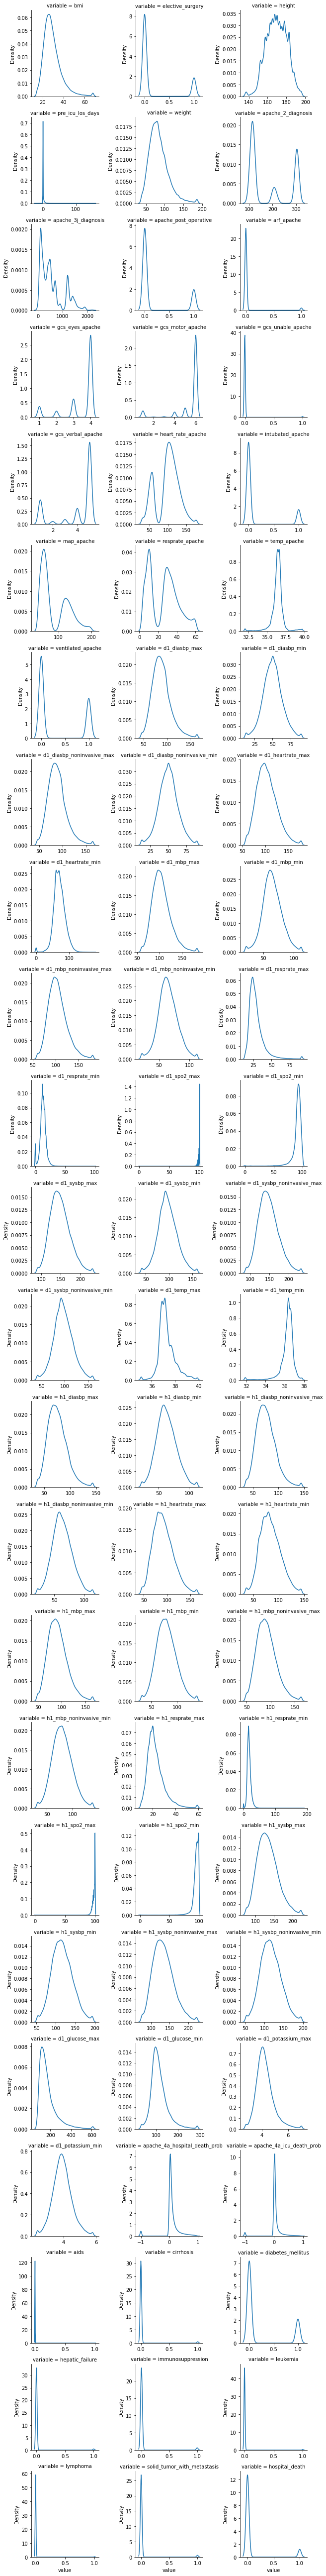

In [25]:
unpivot = pd.melt(raw_data, raw_data.describe().columns[0], raw_data.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

# Preprocessing

converting categorical values  
tranforming numerical columns and removing nulls

Null values for *categories* are replaced by **mode**, and those for *numerical* are replaced by **mean**

In [26]:
numerical_cat = [
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

categorical = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']


In [27]:
raw_data.nunique()[raw_data.nunique() == 2].index.tolist()

['elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis',
 'hospital_death']

In [28]:
raw_data.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [29]:
not_numeric = raw_data[numerical_cat + categorical + ['hospital_death']].columns.tolist()
numeric_only = raw_data.drop(not_numeric,axis=1).columns.tolist()
numeric_only

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'heart_rate_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_sysbp_n

In [30]:
for col in numerical_cat:
    raw_data[col] = raw_data[col].astype('Int64')
    
for col in numerical_cat:
    raw_data[col] = raw_data[col].fillna(raw_data[col].mode()[0])

In [31]:
raw_data[numeric_only].isna().sum(axis=0).sort_values(ascending=False)

d1_potassium_min                 9053
d1_potassium_max                 9053
h1_mbp_noninvasive_min           8455
h1_mbp_noninvasive_max           8455
apache_4a_icu_death_prob         7594
apache_4a_hospital_death_prob    7594
h1_diasbp_noninvasive_max        6982
h1_diasbp_noninvasive_min        6982
h1_sysbp_noninvasive_min         6972
h1_sysbp_noninvasive_max         6972
d1_glucose_min                   5458
d1_glucose_max                   5458
h1_mbp_min                       4287
h1_mbp_max                       4287
h1_resprate_min                  4062
h1_resprate_max                  4062
age                              4055
h1_spo2_min                      3925
h1_spo2_max                      3925
temp_apache                      3884
h1_diasbp_min                    3388
h1_diasbp_max                    3388
h1_sysbp_max                     3379
h1_sysbp_min                     3379
h1_heartrate_min                 2621
h1_heartrate_max                 2621
d1_temp_min 

In [32]:
split_one = raw_data[numeric_only].isna().sum(axis=0).sort_values()[raw_data[numeric_only].isna().sum(axis=0) < 11000].index.tolist()
split_two = raw_data[numeric_only].isna().sum(axis=0).sort_values()[raw_data[numeric_only].isna().sum(axis=0) > 11000].index.tolist()

In [33]:
split_two

[]

In [34]:
for col in split_two:
    raw_data[col] = raw_data[col].fillna(raw_data[col].mean())

process_data = raw_data.dropna(axis=0)

In [35]:
process_data[categorical].nunique()

ethnicity                6
gender                   2
icu_type                 8
apache_3j_bodysystem    11
apache_2_bodysystem     10
dtype: int64

using one-hot encoder because of large range of **unique values** in categories

In [36]:
icu_data = pd.get_dummies(process_data,
    prefix='isin',
    prefix_sep='_',
    columns=categorical,
    drop_first=False)
icu_data.reset_index(drop = True, inplace = True)
icu_data

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,isin_Cardiovascular,isin_Gastrointestinal,isin_Haematologic,isin_Metabolic,isin_Neurologic,isin_Renal/Genitourinary,isin_Respiratory,isin_Trauma,isin_Undefined Diagnoses,isin_Undefined diagnoses
0,68.0,22.730000,0,180.3,0.541667,73.9,113.0,502.01,0,0,...,1,0,0,0,0,0,0,0,0,0
1,77.0,27.420000,0,160.0,0.927778,70.2,108.0,203.01,0,0,...,0,0,0,0,0,0,1,0,0,0
2,67.0,27.560000,0,190.5,0.000694,100.0,301.0,403.01,0,0,...,0,0,0,0,1,0,0,0,0,0
3,72.0,28.257052,1,154.9,0.004861,67.8,303.0,1304.08,1,0,...,0,0,0,0,0,0,1,0,0,0
4,46.0,25.845717,0,167.6,0.000000,72.6,108.0,203.01,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56981,47.0,51.439842,1,195.0,0.033333,186.0,304.0,1406.01,1,0,...,0,1,0,0,0,0,0,0,0,0
56982,54.0,19.770448,0,177.8,0.025694,62.5,109.0,108.01,0,0,...,1,0,0,0,0,0,0,0,0,0
56983,75.0,23.060250,0,177.8,0.298611,72.9,113.0,501.06,0,0,...,1,0,0,0,0,0,0,0,0,0
56984,56.0,47.179671,0,183.0,0.120139,158.0,113.0,501.05,0,0,...,1,0,0,0,0,0,0,0,0,0


In [37]:
icu_data.columns = [x.lower() for x in icu_data.columns.tolist()]
icu_data = icu_data.loc[:,~icu_data.columns.duplicated()]

In [38]:
t = icu_data['arf_apache'].dtype
for col in tqdm(icu_data.columns.tolist()):
    if icu_data[col].values.dtype == 'uint8' or t == icu_data[col].values.dtype:
        icu_data[col] = icu_data[col].astype(int)

100%|██████████| 104/104 [00:00<00:00, 3441.70it/s]


In [39]:
icu_data.dtypes

age                              float64
bmi                              float64
elective_surgery                   int64
height                           float64
pre_icu_los_days                 float64
weight                           float64
apache_2_diagnosis               float64
apache_3j_diagnosis              float64
apache_post_operative              int64
arf_apache                         int64
gcs_eyes_apache                  float64
gcs_motor_apache                 float64
gcs_unable_apache                  int64
gcs_verbal_apache                float64
heart_rate_apache                float64
intubated_apache                   int64
map_apache                       float64
resprate_apache                  float64
temp_apache                      float64
ventilated_apache                  int64
d1_diasbp_max                    float64
d1_diasbp_min                    float64
d1_diasbp_noninvasive_max        float64
d1_diasbp_noninvasive_min        float64
d1_heartrate_max

# Neural Network

In [40]:
X = icu_data.drop(['hospital_death'], axis=1)
y = icu_data['hospital_death']

X_new = X[['apache_4a_hospital_death_prob','apache_4a_icu_death_prob','age','d1_spo2_min','d1_resprate_max','d1_heartrate_min']]

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, 
                                                    random_state=11, 
                                                    stratify = y)

In [41]:
print(X_train.shape)
print(y_train.shape)

(39890, 6)
(39890,)


In [42]:
import keras
from keras.models import Sequential
from keras.layers import Dense


# Neural network
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(3, activation='relu'))
# model.add(Dense(30, activation='relu'))
model.add(Dense(1,activation='sigmoid'))


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

In [43]:
import tensorflow as tf
opt = tf.keras.optimizers.SGD(learning_rate=0.00001)

In [44]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=20, batch_size=64)


2022-02-04 10:32:15.121038: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
624/624 [==============================] - 2s 2ms/step - loss: 1.7765 - accuracy: 0.8120 - val_loss: 0.7484 - val_accuracy: 0.8890
Epoch 2/20
624/624 [==============================] - 1s 2ms/step - loss: 0.6092 - accuracy: 0.8979 - val_loss: 0.4958 - val_accuracy: 0.9021
Epoch 3/20
624/624 [==============================] - 1s 2ms/step - loss: 0.4437 - accuracy: 0.8995 - val_loss: 0.4067 - val_accuracy: 0.8958
Epoch 4/20
624/624 [==============================] - 1s 2ms/step - loss: 0.3992 - accuracy: 0.8936 - val_loss: 0.3871 - val_accuracy: 0.8921
Epoch 5/20
624/624 [==============================] - 1s 2ms/step - loss: 0.3858 - accuracy: 0.8926 - val_loss: 0.3767 - val_accuracy: 0.8934
Epoch 6/20
624/624 [==============================] - 2s 3ms/step - loss: 0.3764 - accuracy: 0.8942 - val_loss: 0.3684 - val_accuracy: 0.8950
Epoch 7/20
624/624 [==============================] - 1s 2ms/step - loss: 0.3686 - accuracy: 0.8964 - val_loss: 0.3611 - val_accuracy: 0.8965
Epoch 

In [46]:
from tensorflow import keras

In [54]:
# m = keras.models.load_model('../input/patient-survival-pb-files')

In [56]:
# m.predict([[1,2,3,4,5,6]])

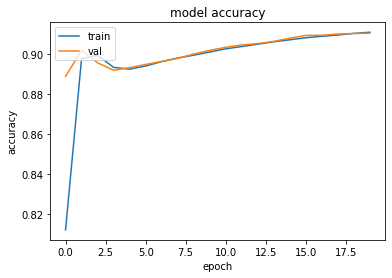

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

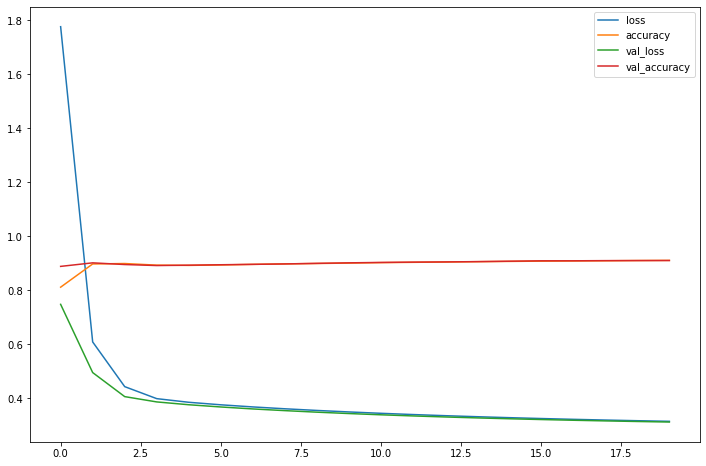

In [58]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.show()

# Modelling

In [59]:
X = icu_data.drop(['hospital_death'], axis=1)
y = icu_data['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=11, 
                                                    stratify = y)

In [60]:
y_train.value_counts()

0    36464
1     3426
Name: hospital_death, dtype: int64

In [61]:
y_test.value_counts()

0    15627
1     1469
Name: hospital_death, dtype: int64

In [63]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                          specs=[ 
#                               [{'colspan': 2}, None],
                                 [{}, {}],
                                 [{}, {}],
                                 
#                                  [{'colspan': 2}, None]
                                ],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
#     fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
#     fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
#     fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
#     fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
#     fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
#     fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
#     fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

# Parameter Tuning

In [71]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

fit_params_of_xgb = {
    "early_stopping_rounds":100, 
    "eval_metric" : 'auc', 
    "eval_set" : [(X_test, y_test)],
    'verbose': 100,
}


# A parameter grid for XGBoost
params = {
    'booster': ["gbtree"],
    'learning_rate': [0.1],
    'n_estimators': range(100, 500, 100),
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'max_depth': [5],
    "scale_pos_weight": [1]
}

xgb_estimator = XGBClassifier(
    objective='binary:logistic',
    # silent=True,
)

gsearch = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=gkf
)

xgb_model = gsearch.fit(X=X_train, y=y_train, **fit_params_of_xgb)
(gsearch.best_params_, gsearch.best_score_)

[0]	validation_0-auc:0.83876
[0]	validation_0-auc:0.84415
[0]	validation_0-auc:0.83876
[0]	validation_0-auc:0.83861
[99]	validation_0-auc:0.87311
[99]	validation_0-auc:0.87503
[99]	validation_0-auc:0.87351
[0]	validation_0-auc:0.84415
[0]	validation_0-auc:0.83876
[0]	validation_0-auc:0.83861
[100]	validation_0-auc:0.87339
[100]	validation_0-auc:0.87493
[100]	validation_0-auc:0.87339
[199]	validation_0-auc:0.87235
[0]	validation_0-auc:0.84415
[100]	validation_0-auc:0.87347
[197]	validation_0-auc:0.87379
[0]	validation_0-auc:0.83861
[200]	validation_0-auc:0.87244
[199]	validation_0-auc:0.87099
[100]	validation_0-auc:0.87493
[0]	validation_0-auc:0.83876
[257]	validation_0-auc:0.87187
[0]	validation_0-auc:0.84415
[100]	validation_0-auc:0.87347
[198]	validation_0-auc:0.87373
[0]	validation_0-auc:0.83861
[100]	validation_0-auc:0.87339
[100]	validation_0-auc:0.87493
[200]	validation_0-auc:0.87104
[200]	validation_0-auc:0.87244
[100]	validation_0-auc:0.87347
[238]	validation_0-auc:0.86978
[198

({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 200,
  'scale_pos_weight': 1,
  'subsample': 0.8},
 0.8843730559449982)

# Final Model Evaluation

In [72]:
xgb_tuned = XGBClassifier(n_estimators=3000,
    objective='binary:logistic',
    booster="gbtree",
    learning_rate=0.01,
    scale_pos_weight=1,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample=0.4,
    colsample_bytree=0.8,
    reg_alpha=0.08,
    n_jobs=-1)

xgb_tuned.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
y__hat = xgb_tuned.predict(X_test._get_numeric_data())

[10:54:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encode

In [74]:
y__hat[21:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [75]:
model_performance(xgb_tuned,y_test, y__hat)

In [76]:
X_test_sample = X_test.sample(2500)
X_test_sample

,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,...,isin_metabolic,isin_musculoskeletal/skin,isin_neurological,isin_respiratory,isin_sepsis,isin_trauma,isin_haematologic,isin_neurologic,isin_renal/genitourinary,isin_undefined diagnoses
46234,60.0,27.717685,0,172.00,0.234028,82.00,113.0,501.05,0,0,...,0,0,0,0,1,0,0,0,0,0
20109,85.0,22.854458,0,153.00,0.175000,53.50,304.0,311.01,0,0,...,0,0,0,0,0,0,0,0,0,0
21052,62.0,24.933720,0,178.00,0.034722,79.00,305.0,901.03,0,0,...,0,0,0,0,0,0,0,0,1,0
11190,69.0,25.069394,0,185.00,0.043056,85.80,113.0,502.01,0,0,...,0,0,0,0,1,0,0,0,0,0
34764,71.0,26.498726,1,177.80,0.268750,83.77,203.0,1206.03,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56470,22.0,17.710416,0,160.02,-0.015278,45.35,122.0,703.03,0,0,...,1,0,0,0,0,0,0,0,0,0
22997,80.0,25.870483,0,180.30,0.202083,84.10,115.0,101.01,0,0,...,0,0,0,0,0,0,0,0,0,0
2182,68.0,33.203125,0,160.00,0.002778,85.00,301.0,403.01,0,0,...,0,0,1,0,0,0,0,1,0,0
37312,55.0,27.645308,0,167.00,0.802083,77.10,122.0,703.03,0,0,...,1,0,0,0,0,0,0,0,0,0
